# Time series
---  
*J. Michelle Hu  
University of Utah  
Aug 2024*  


In [65]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import geopandas as gpd
import xarray as xr
import seaborn as sns

from pathlib import PurePath
from s3fs import S3FileSystem, S3Map

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

# Set seaborn palette
sns.set_palette('icefire')

In [66]:
%reload_ext autoreload
%autoreload 2

### Env setup

In [67]:
from pathlib import PurePath
# Locate pyproj_datadir for studio env
# From https://stackoverflow.com/questions/69630630/on-fresh-conda-installation-of-pyproj-pyproj-unable-to-set-database-path-pypr
CONDA_ENV = 'studio'
miniconda_dir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3'
proj_version = h.fn_list(miniconda_dir, f'envs/{CONDA_ENV}/conda-meta/proj-[0-9]*.json')[0]

VERSION = PurePath(proj_version).stem
pyprojdatadir = f'{miniconda_dir}/pkgs/{VERSION}/share/proj'
print(pyprojdatadir)
pyproj.datadir.set_data_dir(pyprojdatadir)

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj


In [68]:
# pd.options.plotting.backend = 'matplotlib'

### Directories and global variables

In [69]:
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/'
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts'
poly_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/ancillary/polys'
aso_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/ASO'

# SNOTEL all sites geojson fn - snotel site json
allsites_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/ancillary_sdswe_products/SNOTEL/snotel_sites_32613.json'

# nwm proj4 file
proj_fn = "/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/ancillary/NWM_datasets_proj4.txt"

In [129]:
# Basin-specific variables
basin = 'yampa'

In [130]:
# Select just for all variable output of time decay
basindirs = h.fn_list(workdir, f'{basin}*/wy*/{basin}*/')

# Get the WY from the directory name - assumes there is only one WY per basin right now
WYs = [int(basindir.split('wy')[1][:4]) for basindir in basindirs]
WYs = np.unique(WYs)
if len(WYs) == 1:
    pass
else:
    print(f'Multiple water years in {basin} basin: {WYs}')
WY = WYs[0]    
print(WY)

# Figure out filenames
poly_fn = h.fn_list(script_dir, f'*{basin}*setup/polys/*shp')[0]
print(poly_fn)

Multiple water years in yampa basin: [2020 2024]
2020
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/yampa_setup/polys/upper_yampa_basin_outline_32613.shp


### SNOTEL extraction and point specification
- identify SNOTEL sites within the specified basin
- extract site metadata (site name, site number, and coordinates)
- extract snow depth values for WY of interest

In [131]:
# Locate SNOTEL sites within basin
found_sites = proc.locate_snotel_in_poly(poly_fn=poly_fn, site_locs_fn=allsites_fn)

# Get site names and site numbers
sitenames = found_sites['site_name']
sitenums = found_sites['site_num']
print(sitenames)

ST_arr = ['CO'] * len(sitenums)
gdf_metloom, snotel_dfs, snotel_metadf = proc.get_snotel(sitenums, sitenames, ST_arr, WY=WY, return_meta=True)
gdf_metloom

136     Bear River (1061)
145    Buffalo Park (913)
156          Crosho (426)
160        Dry Lake (457)
163       Elk River (467)
188        Lost Dog (940)
211     Rabbit Ears (709)
214    Ripple Creek (717)
229           Tower (825)
Name: site_name, dtype: object


geometry
0  POINT (328619.320 4436520.070)
1  POINT (364200.898 4454327.508)
2  POINT (324779.689 4448377.211)
3  POINT (349126.841 4488519.982)
4  POINT (334051.290 4523702.241)
5  POINT (352550.298 4519754.587)
6  POINT (352169.189 4469985.874)
7  POINT (304500.457 4442315.002)
8  POINT (358015.189 4488756.498)

In [132]:
# Could change this to save snow depth plot to png
# snotel_dfs[sitenames.iloc[0]]["SNOWDEPTH_m"].plot()

### NWM
  
Processed using extract_nwm_timeseries_point.py blue 2019 script to minimize extraction and transformation

In [133]:
nwm_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/ancillary_sdswe_products/NWM/'
nwm_csv = h.fn_list(nwm_dir, f'{basin}/*{WY}.csv')[0]
nwm_df = pd.read_csv(nwm_csv, index_col=0)
nwm_df.index.name = 'Date'

# Set as DatetimeIndex
nwm_df.index = pd.to_datetime(nwm_df.index)
nwm_daily_df = nwm_df.resample('1D').mean()

# Could change this to save snow depth plot to png
# nwm_daily_df.plot()

### SWANN

In [134]:
%%time
# SWANN dir
swann_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/ancillary_sdswe_products/SWANN_SWE_depth'

# Establish filename of time series based on this WY (netcdf much smaller than csv)
swann_ts_fn = f'{swann_dir}/{basin}/{basin}_swann_snotelmetloom_DEPTH_wy{WY}.csv'
print(swann_ts_fn)

# If this file does not exist, process
if not os.path.exists(swann_ts_fn):
    # Get this water year's file
    swann_wy_fn = h.fn_list(swann_dir, f'*{WY}*')

    # Read in the depth variable
    swann_ds = xr.open_mfdataset(swann_wy_fn, drop_variables=["SWE", "time_str"])

    # Reassign coordinate names
    swann_ds = swann_ds.rename({'lat': 'y', 'lon': 'x'})

    # Explicitly write out crs
    swann_ds.rio.write_crs(input_crs=swann_ds.crs.attrs['spatial_ref'],
                           inplace=True)

    # Transform  the x and y coords of snotel sites into this SWANN dst_crs
    gdf_metloom_reproj = gdf_metloom.to_crs(swann_ds.crs.attrs['spatial_ref'])

    # Extract values at snotel coordinates
    swann_data = swann_ds['DEPTH'].sel(x=list(gdf_metloom_reproj.geometry.x.values),
                                       y=list(gdf_metloom_reproj.geometry.y.values),
                                       method='nearest')

    # Convert to a dict and convert depth from millimeters to meters
    swann_dict = dict()
    for jdx, sitename in enumerate(sitenames):
        ds = swann_data[:, jdx, jdx]
        swann_dict[sitename] = ds.values / 1000

    # Turn it into a dataframe
    swann_datadf = pd.DataFrame(swann_dict, index=ds['time'].values)

    # Save the the dataframe as csv for easy access later
    if not os.path.exists(swann_ts_fn):
        swann_basin_dir = f'{swann_dir}/{basin}'
        if not os.path.exists(swann_basin_dir):
            os.makedirs(swann_basin_dir)

    # Write out for next time
    swann_datadf.to_csv(swann_ts_fn)

else:
    swann_datadf = pd.read_csv(swann_ts_fn, index_col=0)
    swann_datadf.index.name = 'Date'
    # Set as DatetimeIndex
    swann_datadf.index = pd.to_datetime(swann_datadf.index)

# Could change this to save snow depth plot to png
# swann_datadf.plot()

/uufs/chpc.utah.edu/common/home/skiles-group3/ancillary_sdswe_products/SWANN_SWE_depth/yampa/yampa_swann_snotelmetloom_DEPTH_wy2020.csv
CPU times: user 4.18 ms, sys: 8 μs, total: 4.19 ms
Wall time: 3.88 ms


### iSnobal output extraction

- iSnobal time decay
- iSnobal HRRR-MODIS

In [135]:
figsize = (18, 4)
linestyles = ['-', '--']
linewidth = 1
marker = None
color = 'k'
snotelcolors = ['dodgerblue', 'gray']
isnobalcolors = ['k', 'coral']
labels = ['iSnobal-HRRR', 'HRRR-MODIS']

In [136]:
%%time
# Takes about 2.5 min
chunks = 'auto'

# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
month = 'run20'
varname = 'snow'

# snow.nc contains these variables as well that we will drop
drop_var_list = ['snow_density', 'specific_mass', 'liquid_water', 'temp_surf', 'temp_lower', 'temp_snowcover', 'thickness_lower', 'water_saturation', 'projection']
thisvar = 'thickness'

ds_dict = dict() 

for kdx, label in enumerate(labels):
    model_ts_fn = f'{PurePath(basindirs[0]).parents[0].as_posix()}/{basin}_{label}_{thisvar}_snotelmetloom_wy{WY}.csv'
    print(model_ts_fn)

    if not os.path.exists(model_ts_fn):
        print("^^DNE, calculating...")
        days = dict()
        basindir = basindirs[kdx]
        basin_days = h.fn_list(basindir, f"{month}*/{varname}.nc")
        days[label] = basin_days

        for d in days.keys():
            print(d)
            print(len(days[d]))

        # extract the snow state variables for the selected sites
        ds_list = [xr.open_dataset(day_fn, chunks=chunks, drop_variables=drop_var_list) for day_fn in days[label]]
        snow_var_data = [ds[thisvar].sel(x=list(gdf_metloom.geometry.x.values), y=list(gdf_metloom.geometry.y.values), method='nearest') for ds in ds_list]
        snow_var_data = xr.concat(snow_var_data, dim='time')
        ds_dict[f'{label}_{thisvar}'] = snow_var_data

        # Turn these into dataframes and write to csvs
        basin_dict = dict()
        for jdx, sitename in enumerate(sitenames):
            ds = ds_dict[f'{label}_{thisvar}'][:, jdx, jdx]
            basin_dict[sitename] = ds.values

        # Turn it into a dataframe
        basin_df = pd.DataFrame(basin_dict, index=ds['time'].values)
        print(model_ts_fn)

        # Save the the dataframe as csv for easy access later
        basin_df.to_csv(model_ts_fn)
    else:
        df = pd.read_csv(model_ts_fn, index_col=0)
        df.index.name = 'Date'
        # Set as DatetimeIndex
        df.index = pd.to_datetime(df.index)
        ds_dict[f'{label}_{thisvar}'] = df

/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/yampa_100m_isnobal/wy2020/yampa_iSnobal-HRRR_thickness_snotelmetloom_wy2020.csv
/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/yampa_100m_isnobal/wy2020/yampa_HRRR-MODIS_thickness_snotelmetloom_wy2020.csv
CPU times: user 6.96 ms, sys: 995 μs, total: 7.96 ms
Wall time: 7.4 ms


### Individual iSnobal line plots

CPU times: user 501 ms, sys: 0 ns, total: 501 ms
Wall time: 503 ms


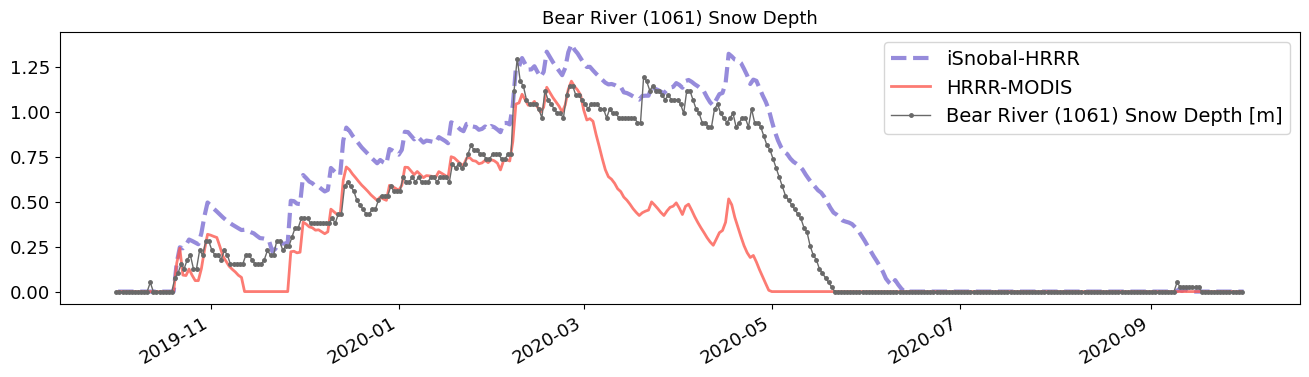

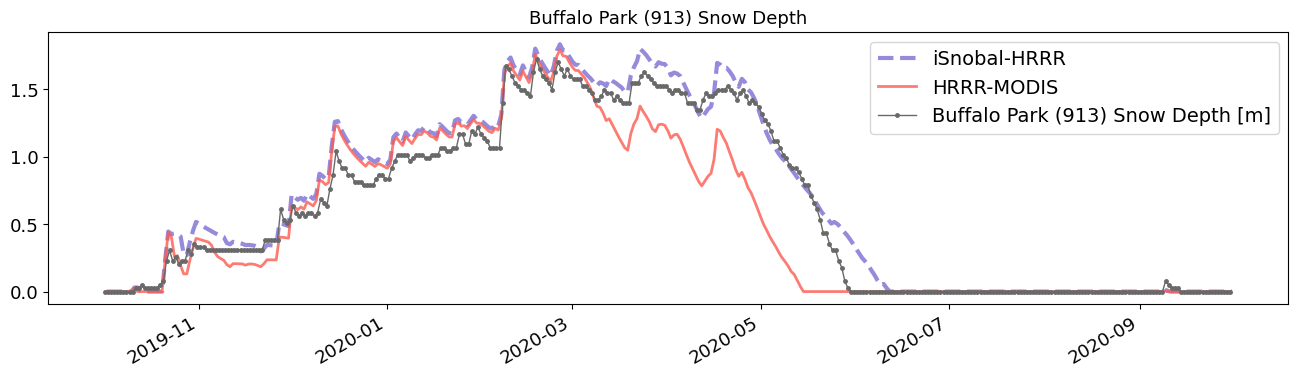

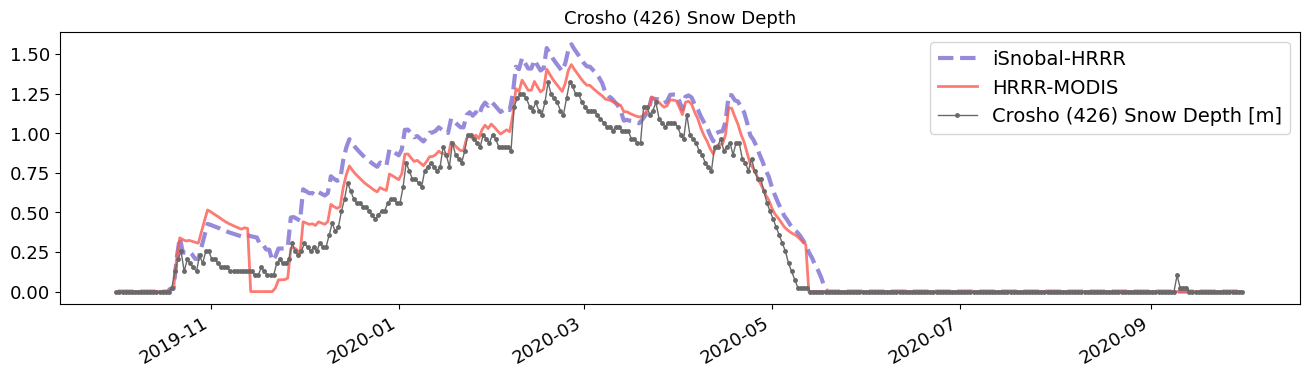

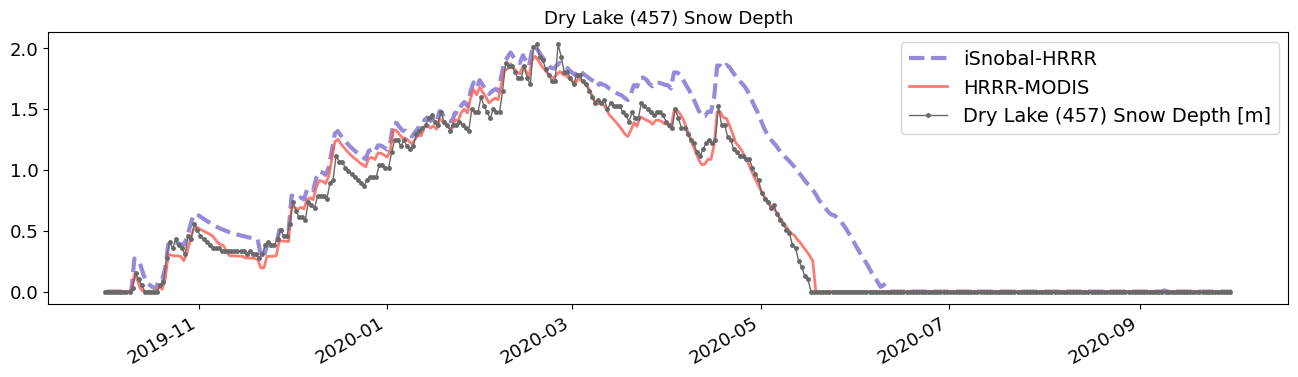

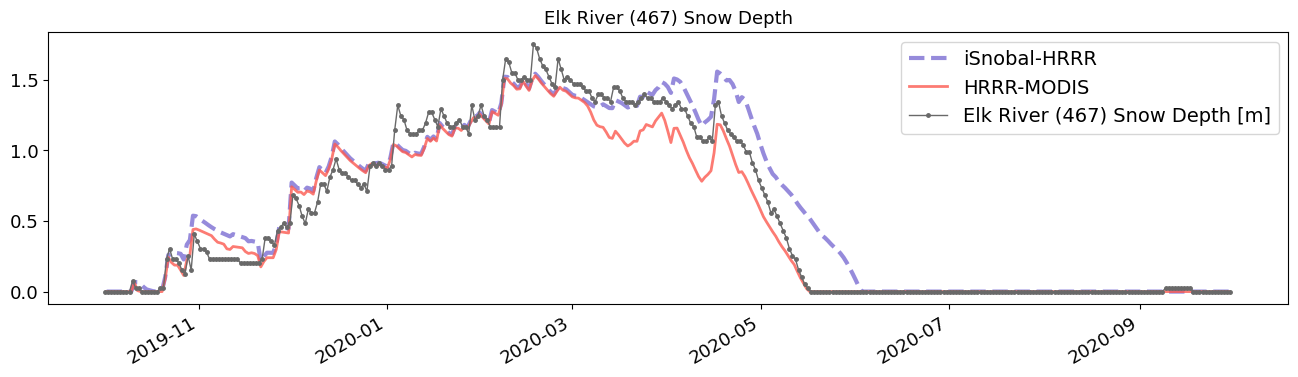

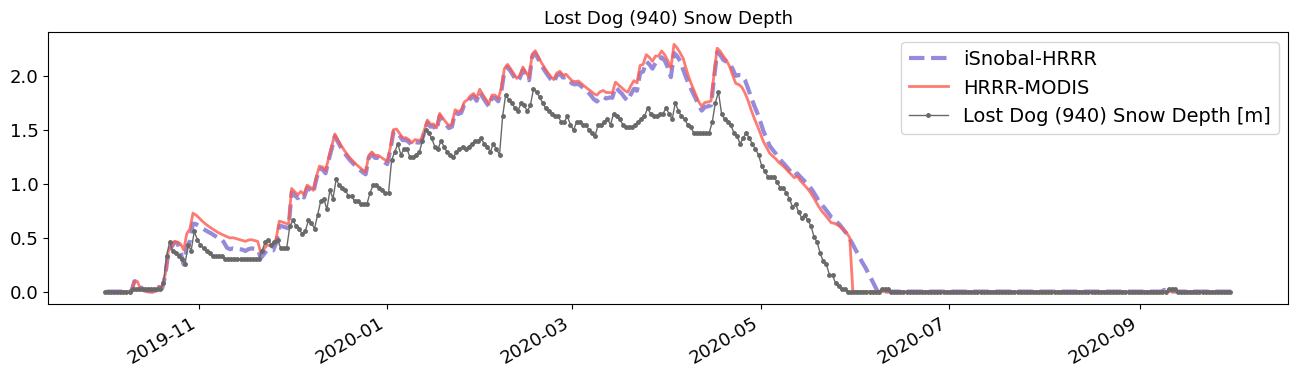

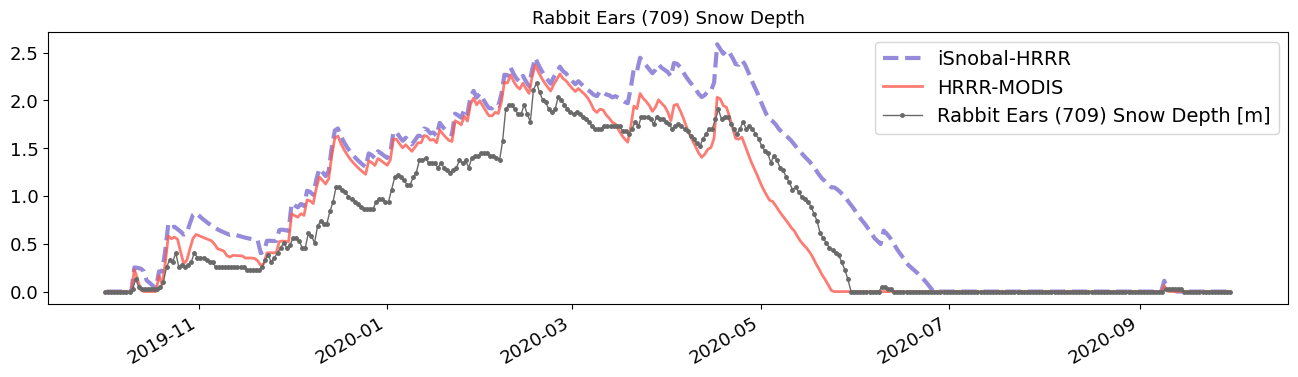

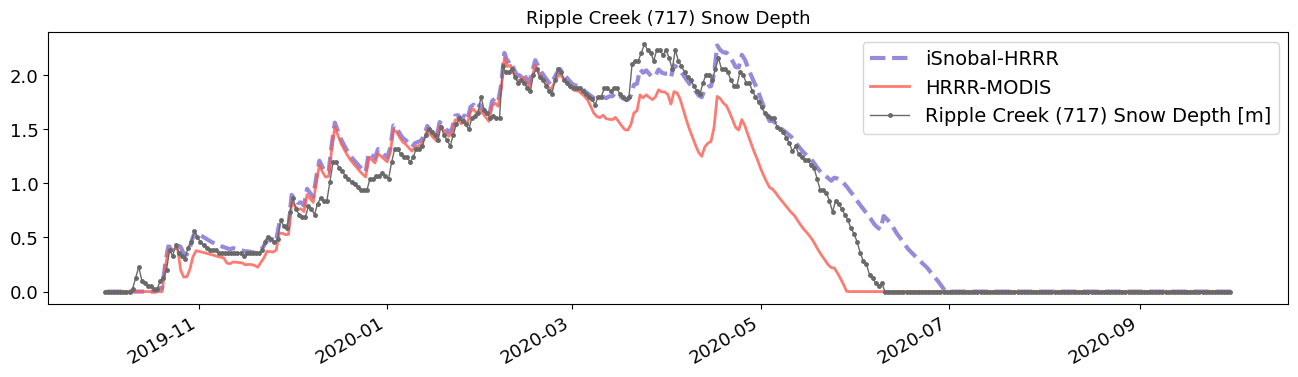

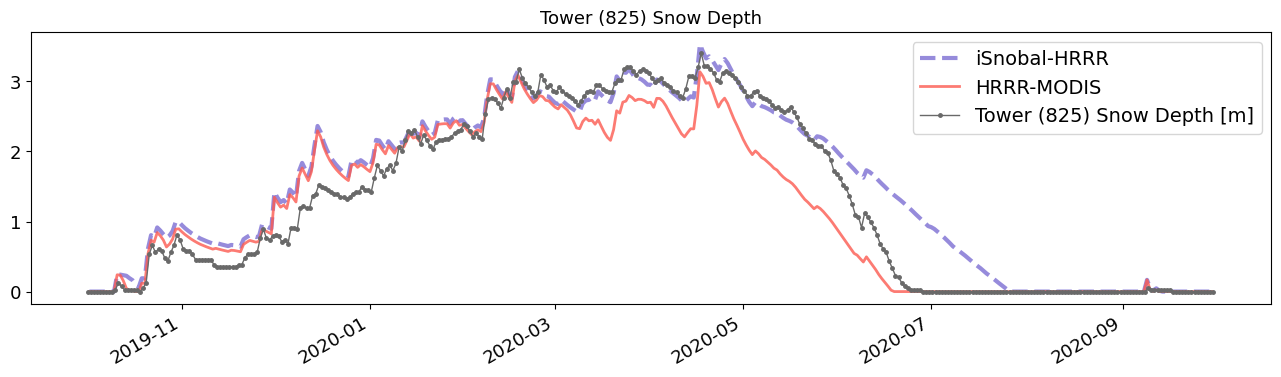

In [137]:
%%time
colors = ['slateblue', 'xkcd:coral']
linestyles = ['--', '-']
linewidths = [3, 2]
alphas = [0.7, 0.8]
for kdx, sitename in enumerate(sitenames):
    fig, ax = plt.subplots(1, figsize=(16, 4))
    for mdx, label in enumerate(labels):
        snow_var_data = ds_dict[f'{label}_{thisvar}']
        snow_var_data[sitename].plot(ax=ax, color=colors[mdx], 
                                        label=label, linewidth=linewidths[mdx], 
                                        linestyle=linestyles[mdx], alpha=alphas[mdx]
                                       )

        
    # Plot WY time series of snow depth
    (snotel_dfs[f'{sitename}']['SNOWDEPTH_m']).plot(ax=ax, label=f'{sitename} Snow Depth [m]', 
                                                    linestyle='-', linewidth=1, color='dimgray',
                                                    marker='.', markersize=5
                                                   )
    plt.legend(bbox_to_anchor=(1,1))
    plt.title(f'{sitename} Snow Depth')
    plt.xlabel('');

### ASO value extraction

In [138]:
%%time
if basin == 'yampa':
    pass
else:
    # Locate ASO snow depth files
    state = 'CO'

    # from https://nsidc.org/sites/nsidc.org/files/technical-references/ASO_Basins.pdf
    # only blue river basin has different names
    basin_name = basin.capitalize() # more recent collections

    # Water year collections should all be post January so this should work
    depth_fns = h.fn_list(aso_dir, f'{state}/*{basin_name}*{WY}*snowdepth*tif')
    # depth_fns = h.fn_list(aso_dir, f'{state}/*{basin_name}*snowdepth*tif')
    if len(depth_fns) == 0:
        depth_fns = h.fn_list(aso_dir, f'{state}/*{basin_name}*/*{basin_name}*snowdepth*tif')
        if len(depth_fns) == 0:
            depth_fns = h.fn_list(aso_dir, f'{state}/*{basin_name}*tif')

    _ = [print(f) for f in depth_fns]

    # Load depth arrays and squeeze out single dimensions
    depth_list = [np.squeeze(xr.open_dataset(fn, chunks=chunks)) for fn in depth_fns]

    # Rename band_data to be more descriptive
    depth_list = [ds.rename_vars({'band_data': 'snow_depth'}) for ds in depth_list]

    # Deal with adding time input for ASO data
    inputvar = '_snowdepth'
    # inputvar = '.'
    depth_list = [np.squeeze(proc.assign_dt(ds, proc.extract_dt(fn, inputvar=inputvar))) for ds, fn in zip(depth_list, depth_fns)]

    # Get dates, could easily just pull from filenames, but this is fine
    date_list = [proc.extract_dt(fn, inputvar=inputvar)[0] for fn in depth_fns]
    date_list = [f.strftime('%Y%m%d') for f in date_list]
    print(date_list)

    # ASO is in EPSG 32613 for USCOBR, same as gdf_metloom. Should be good to go
    print(depth_list[0].rio.crs)

    # Extract ASO snow depth value with NN lookup at snotel sites
    aso_sd_point_list = [] 

    for ds in depth_list:
        # Extract data value from this point based on nearest neighbor lookup (inexact)
        # Coords must be bracketed
        aso_sd_point = ds['snow_depth'].sel(x=list(gdf_metloom.geometry.x.values),
                                        y=list(gdf_metloom.geometry.y.values), 
                                        method='nearest')
        aso_sd_point_list.append(aso_sd_point)

    # Concatenate the list of data arrays into a single dataarray based on time dimension
    aso_depth_ts = xr.concat(aso_sd_point_list, dim='time')

    # Extract into individual time series
    aso_site_ts_list = []
    for jdx, sitenum in enumerate(sitenums):
        # print(jdx)
        aso_site_ts = aso_depth_ts[:, jdx, jdx]
        aso_site_ts_list.append(aso_site_ts)

    # Generate dates for ASO data dataframe
    aso_dt_list = [depth['time'].values for depth in aso_sd_point_list]

    # Put the extracted depths into a dataframe
    aso_depth_ts_df = pd.DataFrame(data=np.array(aso_site_ts_list).T, columns=sitenames, index=aso_dt_list)
    print(aso_depth_ts_df)

    # aso_depth_ts_df.plot(kind='scatter', title='ASO')
    # Could change this to save snow depth plot to png
    # aso_depth_ts_df.plot(linewidth=0, markersize=10, marker='*');

CPU times: user 10 μs, sys: 0 ns, total: 10 μs
Wall time: 17.2 μs


In [139]:
%%time
if basin == 'yampa':
    pass
else:
    # Extract ASO snow depth value with NN lookup at snotel sites
    aso_sd_point_list = [] 

    for ds in depth_list:
        # Extract data value from this point based on nearest neighbor lookup (inexact)
        # Coords must be bracketed
        aso_sd_point = ds['snow_depth'].sel(x=list(gdf_metloom.geometry.x.values),
                                        y=list(gdf_metloom.geometry.y.values), 
                                        method='nearest')
        aso_sd_point_list.append(aso_sd_point)

CPU times: user 8 μs, sys: 1e+03 ns, total: 9 μs
Wall time: 15.3 μs


In [140]:
gdf_snotel = gpd.GeoDataFrame(data=np.array([sitenames, sitenums]).T, columns=['sitenames', 'sitenums'], geometry=gdf_metloom.geometry)
gdf_snotel

sitenames sitenums                        geometry
0   Bear River (1061)     1061  POINT (328619.320 4436520.070)
1  Buffalo Park (913)      913  POINT (364200.898 4454327.508)
2        Crosho (426)      426  POINT (324779.689 4448377.211)
3      Dry Lake (457)      457  POINT (349126.841 4488519.982)
4     Elk River (467)      467  POINT (334051.290 4523702.241)
5      Lost Dog (940)      940  POINT (352550.298 4519754.587)
6   Rabbit Ears (709)      709  POINT (352169.189 4469985.874)
7  Ripple Creek (717)      717  POINT (304500.457 4442315.002)
8         Tower (825)      825  POINT (358015.189 4488756.498)

In [141]:
r = 500

if basin == 'yampa':
    pass
else:
    # Extract ASO snow depth values within a buffered radius of the snotel points
    aso_sd_point_buffer_list = [] 

    for ds in depth_list:
        for row in gdf_snotel.iterrows():
            print(row[1].sitenames)
            small_gdf = gpd.GeoDataFrame(data=np.array([row[1]]), columns=['sitenames', 'sitenums', 'geometry'])
            small_site_buffer = small_gdf.buffer(distance=r)
            aso_clipped = ds.rio.clip(small_site_buffer)
            print(f"Mean | Median : {aso_clipped['snow_depth'].mean().values:.2f} | {np.nanmedian(aso_clipped['snow_depth']):.2f}\n")
            aso_sd_point_buffer_list.append(aso_clipped)

In [142]:
# add to the snotel gdf
site_buffer = gdf_snotel.buffer(distance=r)
gdf_snotel[f'buffered_{r}m'] = site_buffer
gdf_snotel

sitenames sitenums                        geometry  \
0   Bear River (1061)     1061  POINT (328619.320 4436520.070)   
1  Buffalo Park (913)      913  POINT (364200.898 4454327.508)   
2        Crosho (426)      426  POINT (324779.689 4448377.211)   
3      Dry Lake (457)      457  POINT (349126.841 4488519.982)   
4     Elk River (467)      467  POINT (334051.290 4523702.241)   
5      Lost Dog (940)      940  POINT (352550.298 4519754.587)   
6   Rabbit Ears (709)      709  POINT (352169.189 4469985.874)   
7  Ripple Creek (717)      717  POINT (304500.457 4442315.002)   
8         Tower (825)      825  POINT (358015.189 4488756.498)   

                                       buffered_500m  
0  POLYGON ((329119.320 4436520.070, 329116.913 4...  
1  POLYGON ((364700.898 4454327.508, 364698.491 4...  
2  POLYGON ((325279.689 4448377.211, 325277.281 4...  
3  POLYGON ((349626.841 4488519.982, 349624.434 4...  
4  POLYGON ((334551.290 4523702.241, 334548.882 4...  
5  POLYGON ((353050.298 4519754.587, 353047.891 4...  
6  POLYGON ((352669.189 4469985.874, 352666.782 4...  
7  POLYGON ((305000.457 4442315.002, 304998.050 4...  
8  POLYGON ((358515.189 4488756.498, 358512.781 4...

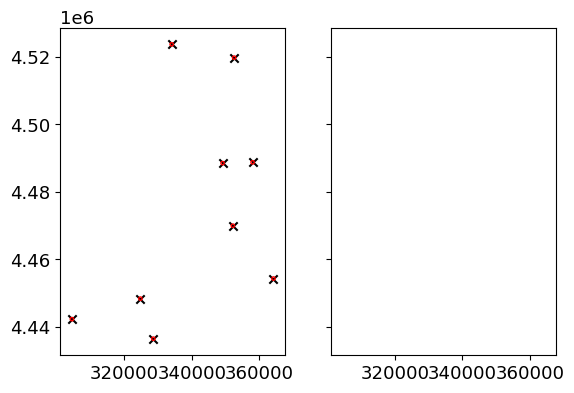

In [143]:
fig, axa = plt.subplots(1, 2, sharex=True, sharey=True)
gdf_snotel.plot(ax=axa[0], marker='x', color='black')
site_buffer.plot(ax=axa[0], marker='o', facecolor='none', edgecolor='r')
axa[0].set_aspect('equal')

if basin == 'yampa':
    pass
else:
    aso_clipped = depth_list[0].rio.clip(site_buffer.geometry)
    aso_clipped['snow_depth'].plot.imshow(vmin=0, vmax=2.5, ax=axa[1])
axa[1].set_aspect('equal')

## Plot

#### Calculate snow disappearance date separately to plot and re-plot quickly

In [144]:
# Disappearance date parameters
snow_name = 'Snow Depth'
verbose = False
# day_thresh = 3
ds_dict.keys()

dict_keys(['iSnobal-HRRR_thickness', 'HRRR-MODIS_thickness'])

In [145]:
%%time
sdd_list = []
for jdx, (sitenum, sitename) in enumerate(zip(sitenums, sitenames)):
    # Extract SNOTEL data for this site
    snotel_df = snotel_dfs[sitename]
    print(f'\n{sitename}')

    # Extract model data for this site
    isnobal_hrrr_ts = ds_dict['iSnobal-HRRR_thickness'][sitename]
    modis_hrrr_ts = ds_dict['HRRR-MODIS_thickness'][sitename]
    # isnobal_hrrr_ts = ds_dict['iSnobal-HRRR_thickness'][:, jdx, jdx]
    # modis_hrrr_ts = ds_dict['HRRR-MODIS_thickness'][:, jdx, jdx]

    # Calculate disappearance dates
    snotel_sdd, _ = proc.calc_sdd(snotel_df['SNOWDEPTH_m'], 
                                snow_name=snow_name, 
                                verbose=verbose)
    print(f'SNOTEL: {snotel_sdd}')
    
    # Convert model data to Pandas Series
    classic_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(isnobal_hrrr_ts), index=isnobal_hrrr_ts.index),
                                snow_name=snow_name, verbose=verbose)
    print(f'Time Decay: {classic_sdd}')

    # Convert model data to Pandas Series
    modis_hrrr_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(modis_hrrr_ts), index=modis_hrrr_ts.index),
                                snow_name=snow_name, verbose=verbose)
    print(f'HRRR-MODIS: {modis_hrrr_sdd}')

    try:
        # # Resample NWM data to daily timestep to smooth hourly blips for SDD calc - handling above
        # nwm_daily = nwm_ds[jdx].resample(time='1D').mean()
        # # nwm_daily = nwm_ds[jdx]
        # nwm_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(nwm_daily.data), index=nwm_daily.time.values),
        #                                 snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
        nwm_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(nwm_daily_df[sitename].values), index=nwm_daily_df.index),
                                        snow_name=snow_name, verbose=verbose)
        print(f'NWM: {nwm_sdd}')
    except:
        print("Something wrong with NWM extract")
        # add default day
        nwm_sdd = pd.Timestamp(year=WY, month=12, day=25)
        
    try:
        swann_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(swann_datadf[sitename].values), index=swann_datadf.index),
                                        snow_name=snow_name, verbose=verbose)
        print(f'SWANN: {swann_sdd}')
    except:
        print("Something wrong with SWANN extract")
        # add default day
        nwm_sdd = pd.Timestamp(year=WY, month=12, day=25)
        
    
              
    sdd_list.append([snotel_sdd, classic_sdd, modis_hrrr_sdd, nwm_sdd, swann_sdd])


Bear River (1061)
SNOTEL: 2020-05-21 08:00:00+00:00
Time Decay: 2020-06-12 22:00:00
HRRR-MODIS: 2020-04-30 22:00:00
NWM: 2020-04-10 00:00:00
SWANN: 2020-05-14 00:00:00

Buffalo Park (913)
SNOTEL: 2020-05-30 08:00:00+00:00
Time Decay: 2020-06-11 22:00:00
HRRR-MODIS: 2020-05-14 22:00:00
NWM: 2020-05-24 00:00:00
SWANN: 2020-05-26 00:00:00

Crosho (426)
SNOTEL: 2020-05-10 08:00:00+00:00
Time Decay: 2020-05-18 22:00:00
HRRR-MODIS: 2020-05-12 22:00:00
NWM: 2020-04-26 00:00:00
SWANN: 2020-05-01 00:00:00

Dry Lake (457)
SNOTEL: 2020-05-17 08:00:00+00:00
Time Decay: 2020-06-11 22:00:00
HRRR-MODIS: 2020-05-18 22:00:00
NWM: 2020-04-29 00:00:00
SWANN: 2020-05-02 00:00:00

Elk River (467)
SNOTEL: 2020-05-17 08:00:00+00:00
Time Decay: 2020-06-02 22:00:00
HRRR-MODIS: 2020-05-16 22:00:00
NWM: 2020-04-30 00:00:00
SWANN: 2020-05-13 00:00:00

Lost Dog (940)
SNOTEL: 2020-05-28 08:00:00+00:00
Time Decay: 2020-06-08 22:00:00
HRRR-MODIS: 2020-05-30 22:00:00
NWM: 2020-06-08 00:00:00
SWANN: 2020-05-30 00:00:0

In [146]:
# Plotting params
linestyles = ['-', '--']
linewidth = 1.5

snotelcolor = 'dimgray'
isnobalcolors = ['mediumblue', 'cornflowerblue']
nwm_color = 'tomato'#'salmon'
swann_color = 'navy'#'tomato'
alpha = 0.7
isnobal_alpha = 0.6

figsize = (8, 4)
figsize = (12, 4)


Bear River (1061)

Buffalo Park (913)

Crosho (426)

Dry Lake (457)

Elk River (467)

Lost Dog (940)

Rabbit Ears (709)

Ripple Creek (717)

Tower (825)
CPU times: user 712 ms, sys: 2.3 ms, total: 714 ms
Wall time: 717 ms


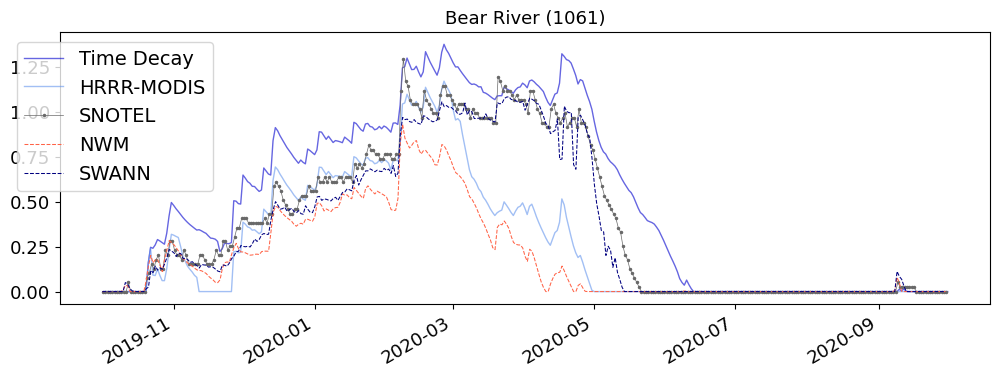

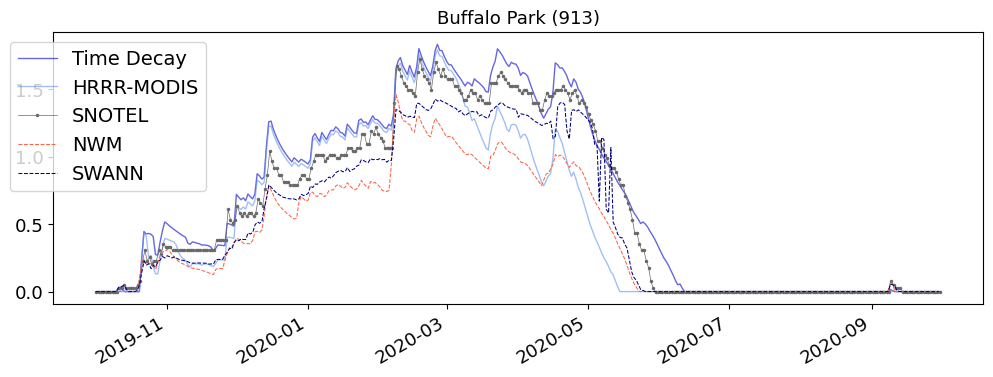

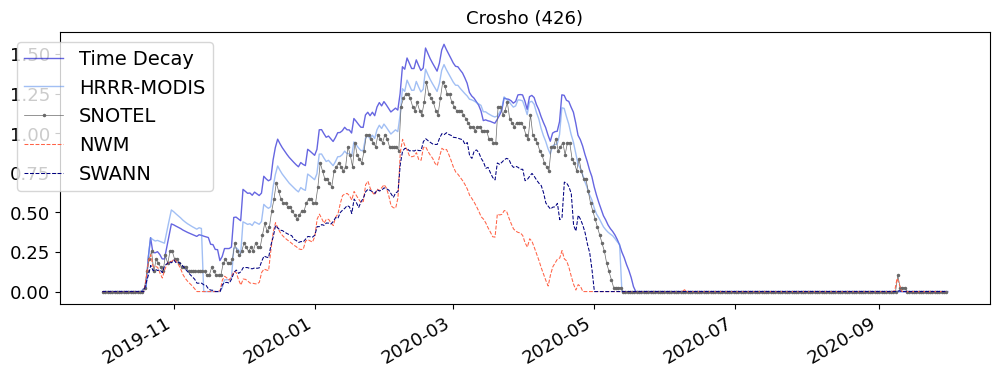

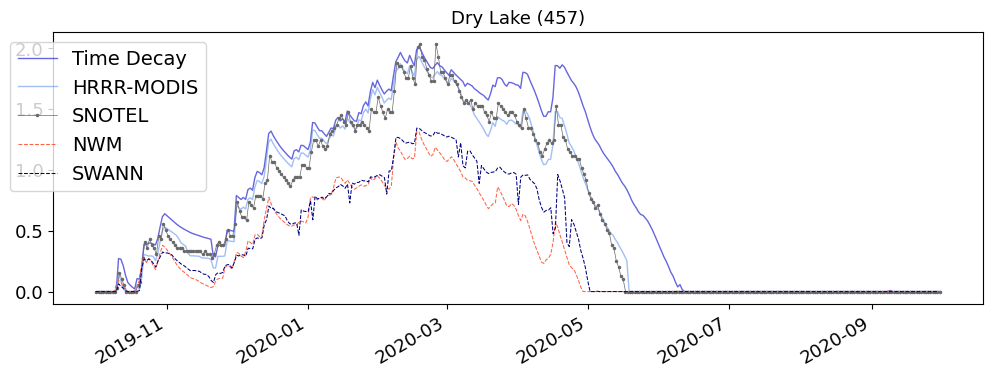

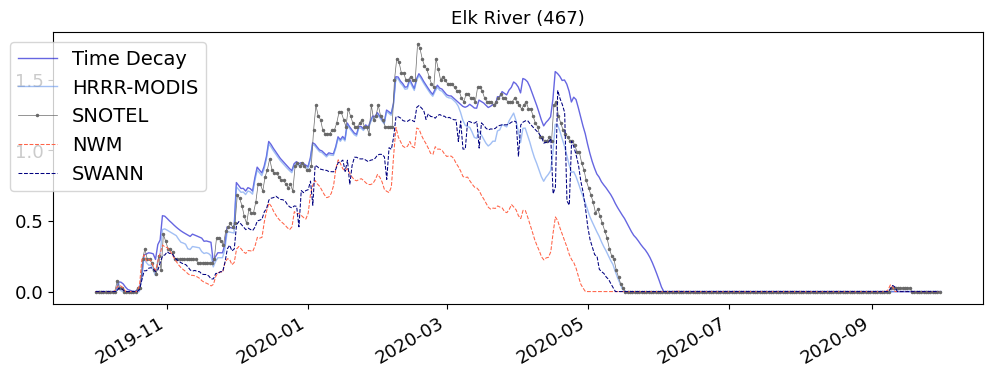

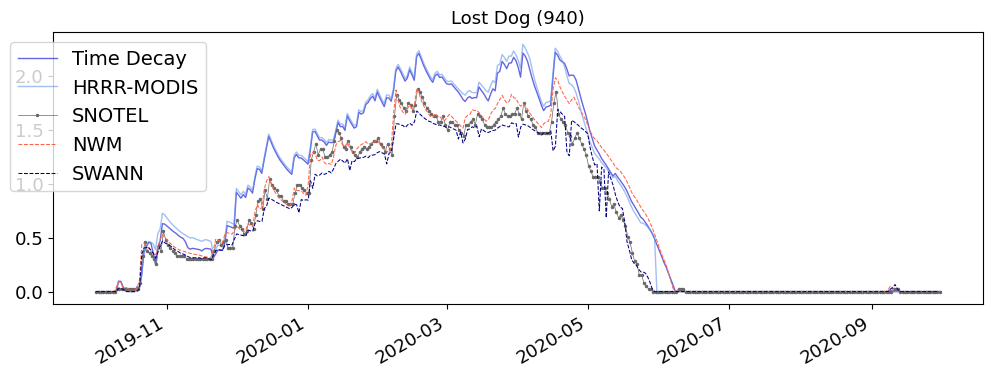

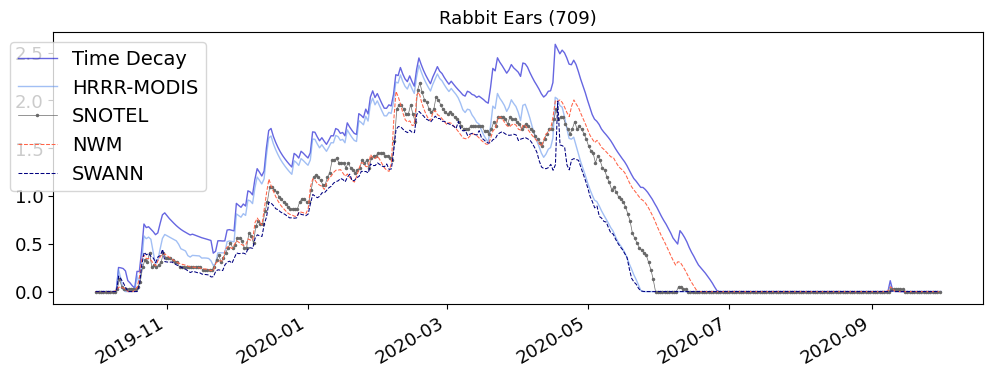

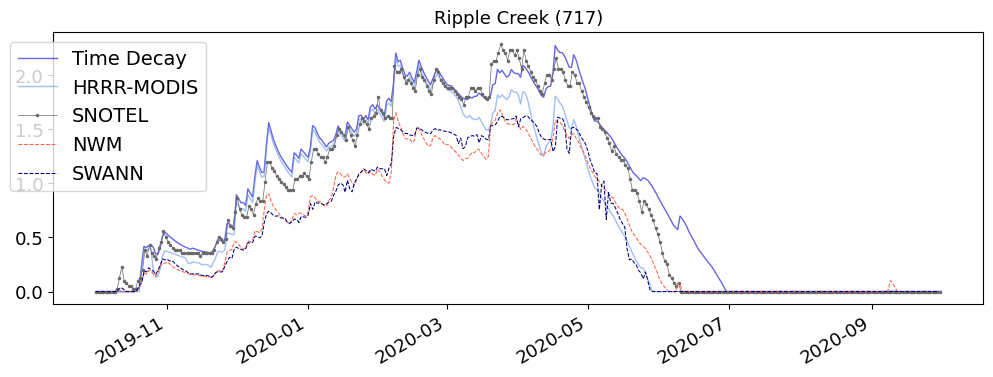

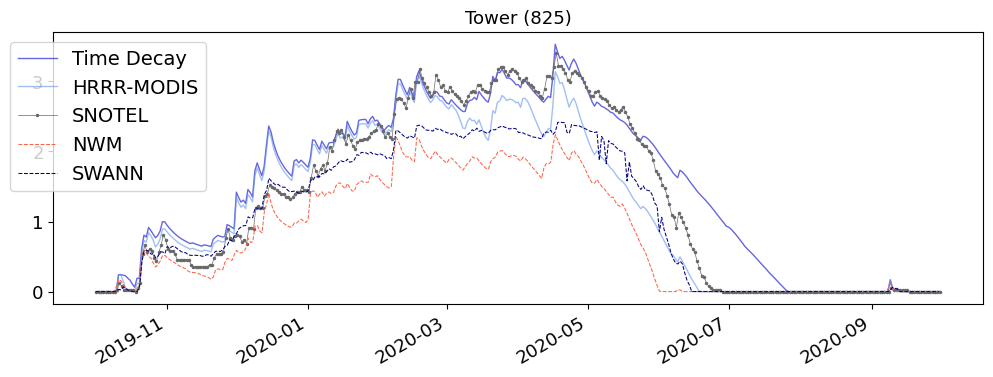

In [147]:
%%time
# No SDD version
for jdx, (sitenum, sitename) in enumerate(zip(sitenums, sitenames)):
    # Extract SNOTEL data for this site
    snotel_df = snotel_dfs[sitename]
    print(f'\n{sitename}')

    # Extract model data for this site
    isnobal_hrrr_ts = ds_dict['iSnobal-HRRR_thickness'][sitename]
    modis_hrrr_ts = ds_dict['HRRR-MODIS_thickness'][sitename]

    # Extract ASO data for this site
    # aso_depth_ts = aso_depth_ts_df[sitename]

    fig, ax = plt.subplots(1, figsize=figsize)

    isnobal_hrrr_ts.plot(ax=ax, color=isnobalcolors[0], label='Time Decay', linewidth=linewidth/3*2, linestyle='-', alpha=isnobal_alpha)
    modis_hrrr_ts.plot(ax=ax, color=isnobalcolors[1], label='HRRR-MODIS', linewidth=linewidth/3*2, linestyle='-', alpha=isnobal_alpha)

    # Plot WY time series of snow depth
    snotel_df['SNOWDEPTH_m'].plot(ax=ax, label=f'SNOTEL',
                                    # linestyle=(0, (3, 1, 1, 1, 1, 1)),
                                    linewidth=linewidth/3,
                                    color=snotelcolor, marker='.', markersize=3,
                                    )
    
    nwm_daily_df[sitename].plot(ax=ax, color=nwm_color, label='NWM', linewidth=linewidth/2, linestyle='--')
    swann_datadf[sitename].plot(ax=ax, color=swann_color, label='SWANN', linewidth=linewidth/2, linestyle='--')
    
    if basin == 'yampa':
        pass
    else:
        aso_depth_ts_df[sitenames.iloc[jdx]].plot(ax=ax, marker='o', markersize=4, linewidth=0, label='ASO', color='maroon', alpha=alpha)

    plt.legend(bbox_to_anchor=(0.175,1), alignment='center') # for (12,4) figsize
    # plt.legend(bbox_to_anchor=(0.26,1), alignment='center') # for (8,4) figsize
    # plt.legend(bbox_to_anchor=(1,-0.1), ncol=4, alignment='center')
    plt.title(f'{sitename}')
    plt.xlabel('');


Bear River (1061)
HRRR-MODIS SDD - SNOTEL SDD: -20 days +00:00:00
Time Decay SDD - SNOTEL SDD: 23 days 00:00:00

Buffalo Park (913)
HRRR-MODIS SDD - SNOTEL SDD: -15 days +00:00:00
Time Decay SDD - SNOTEL SDD: 13 days 00:00:00

Crosho (426)
HRRR-MODIS SDD - SNOTEL SDD: 3 days 00:00:00
Time Decay SDD - SNOTEL SDD: 9 days 00:00:00

Dry Lake (457)
HRRR-MODIS SDD - SNOTEL SDD: 2 days 00:00:00
Time Decay SDD - SNOTEL SDD: 26 days 00:00:00

Elk River (467)
HRRR-MODIS SDD - SNOTEL SDD: 0 days 00:00:00
Time Decay SDD - SNOTEL SDD: 17 days 00:00:00

Lost Dog (940)
HRRR-MODIS SDD - SNOTEL SDD: 3 days 00:00:00
Time Decay SDD - SNOTEL SDD: 12 days 00:00:00

Rabbit Ears (709)
HRRR-MODIS SDD - SNOTEL SDD: -5 days +00:00:00
Time Decay SDD - SNOTEL SDD: 28 days 00:00:00

Ripple Creek (717)
HRRR-MODIS SDD - SNOTEL SDD: -10 days +00:00:00
Time Decay SDD - SNOTEL SDD: 22 days 00:00:00

Tower (825)
HRRR-MODIS SDD - SNOTEL SDD: -6 days +00:00:00
Time Decay SDD - SNOTEL SDD: 32 days 00:00:00


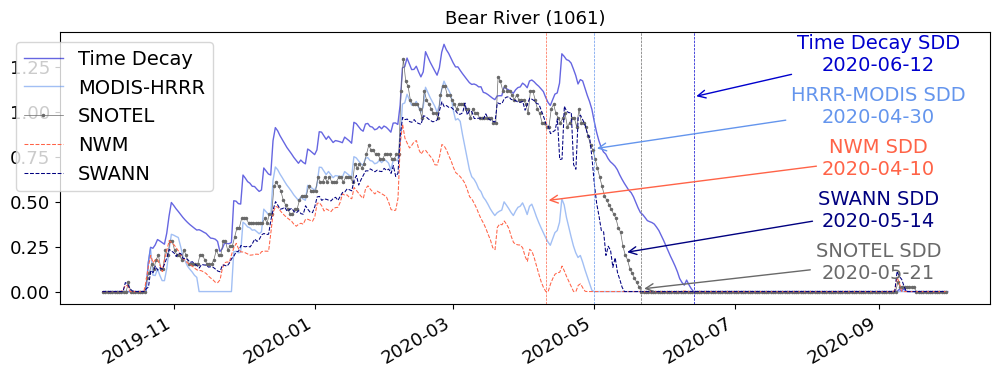

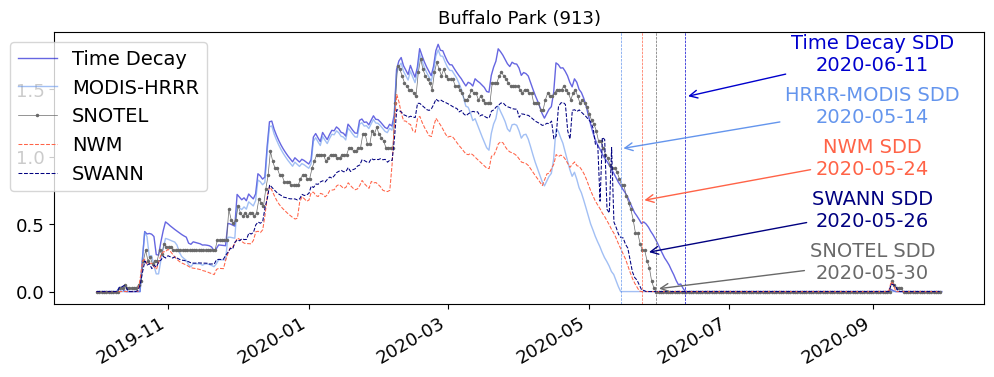

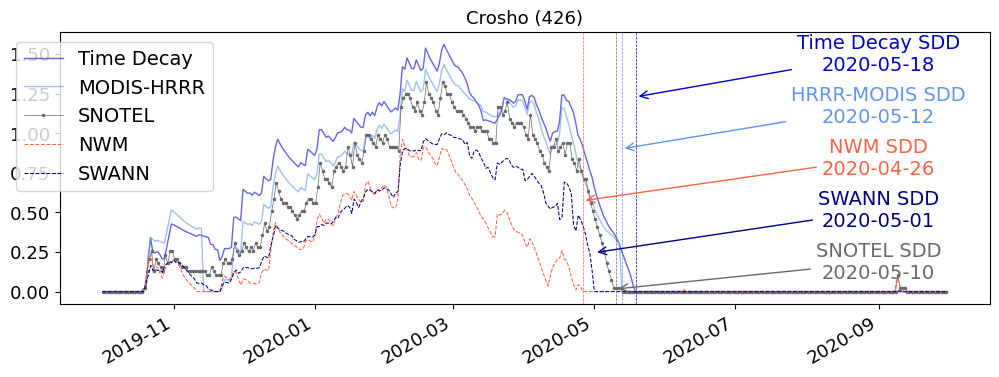

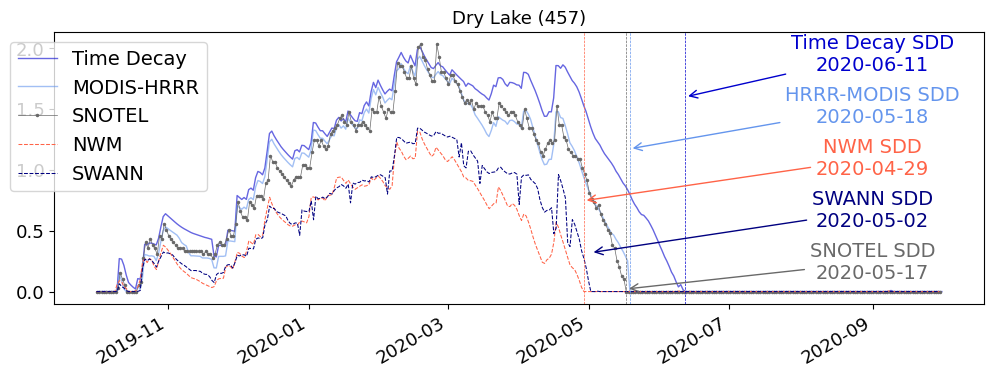

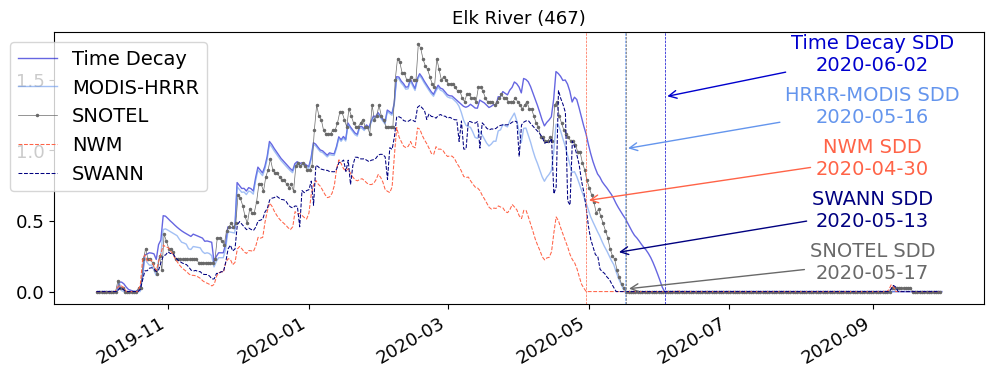

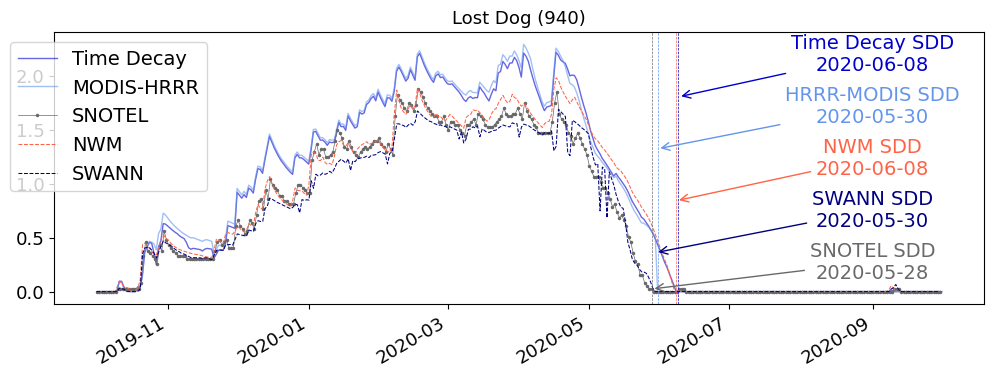

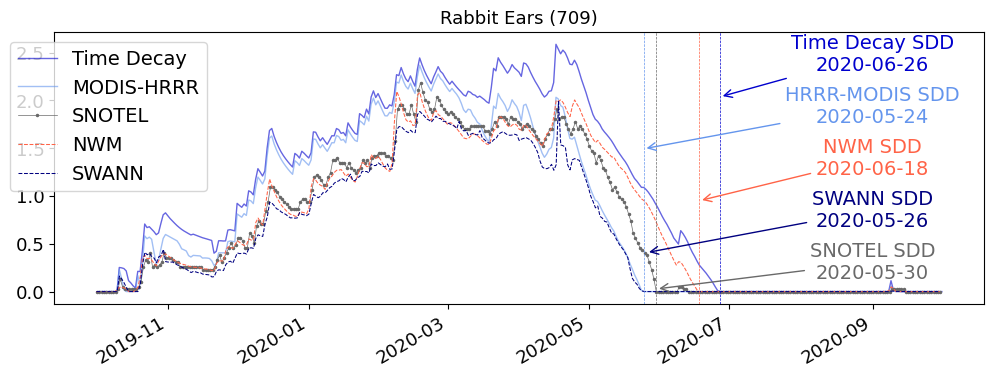

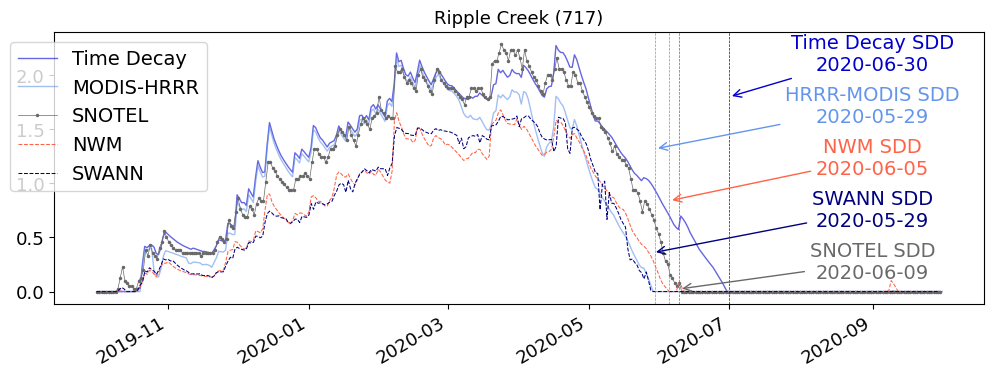

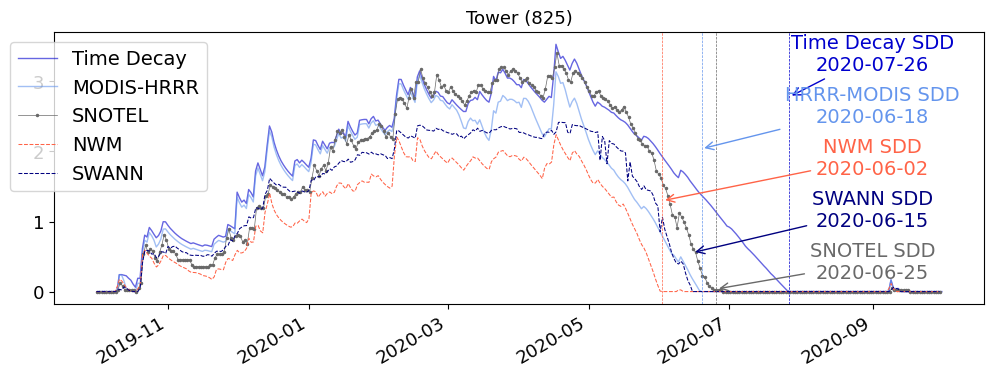

In [148]:
# Day differences from SNOTEL SDD
diff_hrrr_modis = []
diff_baseline = []
for jdx, (sitenum, sitename, sdds) in enumerate(zip(sitenums, sitenames, sdd_list)):
    # Extract SNOTEL data for this site
    snotel_df = snotel_dfs[sitename]
    print(f'\n{sitename}')

    # Extract model data for this site
    isnobal_hrrr_ts = ds_dict['iSnobal-HRRR_thickness'][sitename]
    modis_hrrr_ts = ds_dict['HRRR-MODIS_thickness'][sitename]

    # Extract ASO data for this site
    # aso_depth_ts = aso_depth_ts_df[sitename]

    # Calculate disappearance dates
    snotel_sdd, classic_sdd, modis_hrrr_sdd, nwm_sdd, swann_sdd = sdds 

    # Print the difference from snotel for HRRR-MODIS
    print(f'HRRR-MODIS SDD - SNOTEL SDD: {(modis_hrrr_sdd - snotel_sdd.tz_localize(None)).round("D")}')
    diff_hrrr_modis.append((modis_hrrr_sdd - snotel_sdd.tz_localize(None)).round("D"))
    
    # Print the difference from snotel for baseline
    print(f'Time Decay SDD - SNOTEL SDD: {(classic_sdd - snotel_sdd.tz_localize(None)).round("D")}')
    diff_baseline.append((classic_sdd - snotel_sdd.tz_localize(None)).round("D"))
    
    fig, ax = plt.subplots(1, figsize=figsize)

    isnobal_hrrr_ts.plot(ax=ax, color=isnobalcolors[0], label='Time Decay', linewidth=linewidth/3*2, linestyle='-', alpha=isnobal_alpha)
    modis_hrrr_ts.plot(ax=ax, color=isnobalcolors[1], label='MODIS-HRRR', linewidth=linewidth/3*2, linestyle='-', alpha=isnobal_alpha)

    # Plot WY time series of snow depth
    snotel_df['SNOWDEPTH_m'].plot(ax=ax, label=f'SNOTEL',
                                    # linestyle=(0, (3, 1, 1, 1, 1, 1)),
                                    linewidth=linewidth/3,
                                    color=snotelcolor, marker='.', markersize=3,
                                    )
    
    nwm_daily_df[sitename].plot(ax=ax, color=nwm_color, label='NWM', linewidth=linewidth/2, linestyle='--')
    swann_datadf[sitename].plot(ax=ax, color=swann_color, label='SWANN', linewidth=linewidth/2, linestyle='--')    

    if basin == 'yampa':
        pass
    else:
        aso_depth_ts_df[sitenames.iloc[jdx]].plot(ax=ax, marker='o', markersize=4, linewidth=0, label='ASO', color='maroon', alpha=alpha)

    plt.legend(bbox_to_anchor=(0.175,1), alignment='center') # for (12,4) figsize
    # plt.legend(bbox_to_anchor=(0.26,1), alignment='center') # for (8,4) figsize
    # plt.legend(bbox_to_anchor=(1,-0.1), ncol=4, alignment='center')
    plt.title(f'{sitename}')
    plt.xlabel('');
    
    # Add callouts of disappearance dates with vertical lines
    vlinestyle = '--'
    vlinewidth = 0.5
    plt.axvline(snotel_sdd, color=snotelcolor, linestyle=vlinestyle, linewidth=vlinewidth, label='SNOTEL SDD')
    plt.axvline(classic_sdd, color=isnobalcolors[0], linestyle=vlinestyle, linewidth=vlinewidth, label='Time Decay SDD')
    plt.axvline(modis_hrrr_sdd, color=isnobalcolors[1], linestyle=vlinestyle, linewidth=vlinewidth, label='HRRR-MODIS SDD')
    plt.axvline(nwm_sdd, color=nwm_color, linestyle=vlinestyle, linewidth=vlinewidth, label='NWM SDD')

    # Add arrows pointing left towards the vertical lines above, in the same color as the line
    # get fraction of max y value for the y position of the arrow
    ymax = ax.get_ylim()[1]

    timedelta = pd.Timedelta(days=30)
    timedelta_text = pd.Timedelta(days=60)
    max_dist = pd.Timestamp(f'{snotel_sdd.year}-09-01')
    plt.annotate(f'SNOTEL SDD\n{snotel_sdd.strftime("%Y-%m-%d")}', xy=(snotel_sdd, ymax*0.01), 
                 xytext=(max_dist, ymax*0.05),
                color=snotelcolor, arrowprops=dict(color=snotelcolor, arrowstyle='->'), ha='center')
    plt.annotate(f'Time Decay SDD\n{classic_sdd.strftime("%Y-%m-%d")}', xy=(classic_sdd, ymax*0.75), 
                 xytext=(max_dist, ymax*0.85),
                color=isnobalcolors[0], arrowprops=dict(color=isnobalcolors[0], arrowstyle='->'), ha='center')
    plt.annotate(f'HRRR-MODIS SDD\n{modis_hrrr_sdd.strftime("%Y-%m-%d")}', xy=(modis_hrrr_sdd, ymax*0.55), 
                 xytext=(max_dist, ymax*0.65),                 
                color=isnobalcolors[1], arrowprops=dict(color=isnobalcolors[1], arrowstyle='->'), ha='center')
    plt.annotate(f'NWM SDD\n{nwm_sdd.strftime("%Y-%m-%d")}', xy=(nwm_sdd, ymax*0.35), 
                 xytext=(max_dist, ymax*0.45),
                color=nwm_color, arrowprops=dict(color=nwm_color, arrowstyle='->'), ha='center')
    plt.annotate(f'SWANN SDD\n{swann_sdd.strftime("%Y-%m-%d")}', xy=(swann_sdd, ymax*0.15), 
                 xytext=(max_dist, ymax*0.25),
                color=swann_color, arrowprops=dict(color=swann_color, arrowstyle='->'), ha='center')

In [149]:
diff_hrrr_modis

[Timedelta('-20 days +00:00:00'),
 Timedelta('-15 days +00:00:00'),
 Timedelta('3 days 00:00:00'),
 Timedelta('2 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('3 days 00:00:00'),
 Timedelta('-5 days +00:00:00'),
 Timedelta('-10 days +00:00:00'),
 Timedelta('-6 days +00:00:00')]

In [150]:
diff_baseline

[Timedelta('23 days 00:00:00'),
 Timedelta('13 days 00:00:00'),
 Timedelta('9 days 00:00:00'),
 Timedelta('26 days 00:00:00'),
 Timedelta('17 days 00:00:00'),
 Timedelta('12 days 00:00:00'),
 Timedelta('28 days 00:00:00'),
 Timedelta('22 days 00:00:00'),
 Timedelta('32 days 00:00:00')]

In [151]:
print(np.array(diff_hrrr_modis).mean(), np.median(np.array(diff_hrrr_modis)))
print(np.array(diff_baseline).mean(), np.median(np.array(diff_baseline)))

-6 days +16:00:00 -5 days +00:00:00
20 days 05:20:00 22 days 00:00:00


## One issue with df storage is that xs and ys are not kept

In [152]:
# for jdx, (x, y) in enumerate(zip(gdf_metloom.geometry.x, gdf_metloom.geometry.y)):
#     # print(x, y)
#     print(f'Diff with coords at {sitenames.iloc[jdx]}')
#     print(f'  iSnobal')
#     print(f'    x: {ds_dict['iSnobal-HRRR_thickness'].x.values[jdx] - x:.1f} m')
#     print(f'    y: {ds_dict['iSnobal-HRRR_thickness'].y.values[jdx] - y:.1f} m')
    
#     print(f'  ASO')
#     print(f'    x: {aso_depth_ts.x.values[jdx] - x:.1f} m')
#     print(f'    y: {aso_depth_ts.y.values[jdx] - y:.1f} m')

#     # print('Diff with ASO coords')

## nearest neighbor lookup is quick but the locations are up to 50 m off. averaging values over a distance would be a good idea --> recall that cell sizes for ASO are 3 m, NWM are 1 km, and iSnobal is 100 m.

# Compress these into ranges

#### find the minimum and maximum of all the snotel coords

In [153]:
depth_list = []
depth_sol_list = []
nwm_list = []
swann_list = []
snotel_list = []

for jdx, (sitenum, sitename, sdds) in enumerate(zip(sitenums, sitenames, sdd_list)):
    depth_list.append(ds_dict['iSnobal-HRRR_thickness'][sitename])
    depth_sol_list.append(ds_dict['HRRR-MODIS_thickness'][sitename])
    nwm_list.append(nwm_daily_df[sitename])
    swann_list.append(swann_datadf[sitename])
    snotel_list.append(snotel_dfs[sitenames.iloc[jdx]]['SNOWDEPTH_m'])

In [154]:
depth_megadf = pd.concat(depth_list, axis=1)
depth_megadf.columns = sitenames

depth_sol_megadf = pd.concat(depth_sol_list, axis=1)
depth_sol_megadf.columns = sitenames

nwm_megadf = pd.concat(nwm_list, axis=1)
nwm_megadf.columns = sitenames

swann_megadf = pd.concat(swann_list, axis=1)
swann_megadf.columns = sitenames

snotel_megadf = pd.concat(snotel_list, axis=1)
snotel_megadf.columns = sitenames

## Plot summary figure

In [155]:
SMALL_SIZE = 8
MEDIUM_SIZE = 13
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

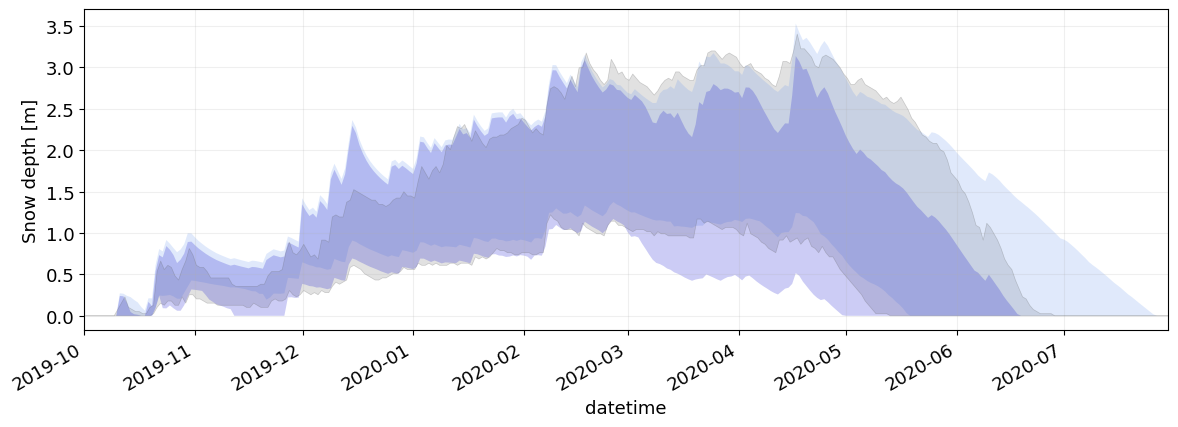

In [156]:
alpha = 0.1
fig, ax = plt.subplots(1, figsize=(12, 4.5))

snotelon = True
snotel_dotson = False
nwmon = False
swannon = False
timedecayon = True
modishrron = True
gridon = True

if snotelon:
    # Plot WY time series of snow depth
    if snotel_dotson:
        snotel_megadf.plot(ax=ax, legend=False,
                           linewidth=linewidth/3,
                           color=snotelcolor, marker='.', markersize=3,
                           alpha=alpha*2
                          )

    snotel_megadf.min(axis=1).plot(ax=ax, legend=False,
                                   # linewidth=0,
                                   linewidth=linewidth/3,
                                   color=snotelcolor, marker='.', markersize=0, #markersize=3,
                                   alpha=alpha*3
                                  )

    snotel_megadf.max(axis=1).plot(ax=ax, legend=False,
                                   # linewidth=0,
                                   linewidth=linewidth/3,
                                   color=snotelcolor, marker='.', markersize=0, #markersize=3,
                                   alpha=alpha*3
                                  )

    ax.fill_between(snotel_megadf.index, 
                    snotel_megadf.min(axis=1), 
                    snotel_megadf.max(axis=1), facecolor=snotelcolor, label='SNOTEL', 
                    alpha=alpha*2)

# iSnobal-HRRR
if timedecayon:
    ax.fill_between(depth_megadf.index, depth_megadf.min(axis=1), depth_megadf.max(axis=1), 
                    facecolor=isnobalcolors[1], 
                    label='Baseline', alpha=isnobal_alpha/3)
    # depth_megadf.plot(ax=ax, label='iSnobal-HRRR', linewidth=linewidth*2, linestyle='-', 
    #                   alpha=isnobal_alpha/2
    #                  )
    # depth_megadf.min(axis=1).plot(ax=ax, label='Time Decay min', linewidth=linewidth*2, linestyle='-', 
    #                               alpha=isnobal_alpha/2,
    #                              )
    # depth_megadf.max(axis=1).plot(ax=ax, label='Time Decay max', linewidth=linewidth*2, linestyle='-', 
    #                               alpha=isnobal_alpha/2
    #                              )

# NWM
if nwmon:
    ax.fill_between(nwm_megadf.index, nwm_megadf.min(axis=1), nwm_megadf.max(axis=1), facecolor='k', label='NWM', alpha=alpha)
    nwm_megadf.min(axis=1).plot(ax=ax, legend=False,
                       # linewidth=0,
                       # linewidth=linewidth,
                       linewidth=linewidth/3,
                       color='k', marker='.', markersize=0, #markersize=3,
                       alpha=alpha
                      )

    nwm_megadf.max(axis=1).plot(ax=ax, legend=False,
                       # linewidth=0,
                       # linewidth=linewidth,
                       linewidth=linewidth/3,
                       color='k', marker='.', markersize=0, #markersize=3,
                       alpha=alpha
                      )
    
    
if swannon:
    ax.fill_between(swann_megadf.index, swann_megadf.min(axis=1), swann_megadf.max(axis=1), facecolor=swann_color, label='SWANN', alpha=alpha)
    swann_megadf.min(axis=1).plot(ax=ax, legend=False,
                       # linewidth=0,
                       # linewidth=linewidth,
                       linewidth=linewidth/3,
                       color=swann_color, marker='.', markersize=0, #markersize=3,
                       alpha=alpha
                      )

    swann_megadf.max(axis=1).plot(ax=ax, legend=False,
                       # linewidth=0,
                       # linewidth=linewidth,
                       linewidth=linewidth/3,
                       color=swann_color, marker='.', markersize=0, #markersize=3,
                       alpha=alpha/2
                      )
    
# HRRR-MODIS
if modishrron:
    ax.fill_between(depth_sol_megadf.index, depth_sol_megadf.min(axis=1),depth_sol_megadf.max(axis=1), facecolor=isnobalcolors[0], label='HRRR-MODIS', alpha=isnobal_alpha/3)
    # depth_sol_megadf.plot(ax=ax, label='HRRR-MODIS', linewidth=linewidth/3*2, linestyle='--', 
    #                       color=sns.color_palette('icefire'),
    #                      )
    # depth_sol_megadf.min(axis=1).plot(ax=ax, label='HRRR-MODIS min', 
    #                                   linewidth=linewidth*2, linestyle='-', 
    #                                   # linewidth=linewidth/3*2, linestyle='--', 
    #                                   # color=sns.color_palette('icefire'),
    #                                  )
    # depth_sol_megadf.max(axis=1).plot(ax=ax, label='HRRR-MODIS max', 
    #                                   linewidth=linewidth*2, linestyle='-', 
    #                                   # linewidth=linewidth/3*2, linestyle='--',
    #                                  )

    
# Center the plot on the data
ax.set_xlim(pd.Timestamp(f'{WY-1}-10-01'), pd.Timestamp(f'{WY}-07-30'));
ax.set_ylabel('Snow depth [m]')
# plt.legend()
plt.tight_layout()
if gridon:
    ax.grid(alpha=0.2)
# plt.legend(bbox_to_anchor=(0.205,1))
# plt.legend(bbox_to_anchor=(0.195,1))
outname = f'{basin}_ts.png'
# outname = f'{basin}_snotel_nwm_ts.png'
# outname = f'{basin}_snotel.png'
plt.savefig(outname, dpi=300)

In [157]:
# switch back to reprojected arrays to keep terrain stuff straightforward for now
if True:
    raise SystemExit("Stop right there!")

SystemExit: Stop right there!

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/studio/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Plot individual datasets

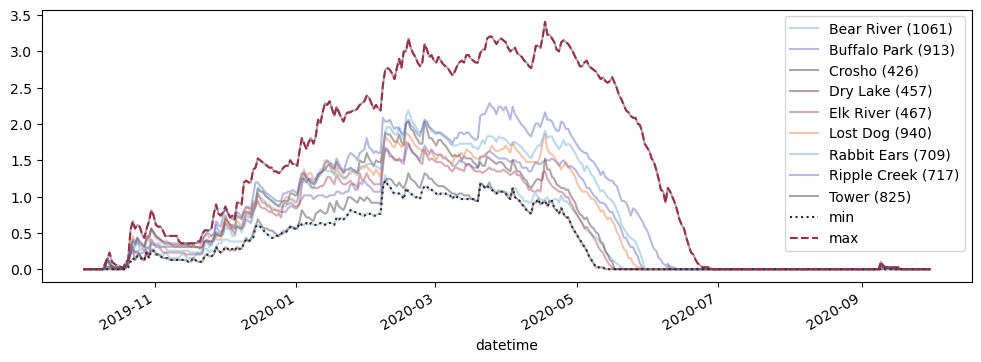

In [ ]:
# snotel_megadf
fig, ax = plt.subplots(1, figsize=(12, 4))
for jdx, (sitenum, sitename, sdds) in enumerate(zip(sitenums, sitenames, sdd_list)):
    snotel_megadf[sitenames.iloc[jdx]].plot(ax=ax, label=sitenames.iloc[jdx], alpha=0.4)
snotel_megadf.min(axis=1).plot(ax=ax, label='min', linestyle=':')
snotel_megadf.max(axis=1).plot(ax=ax, label='max', linestyle='--')
plt.legend()

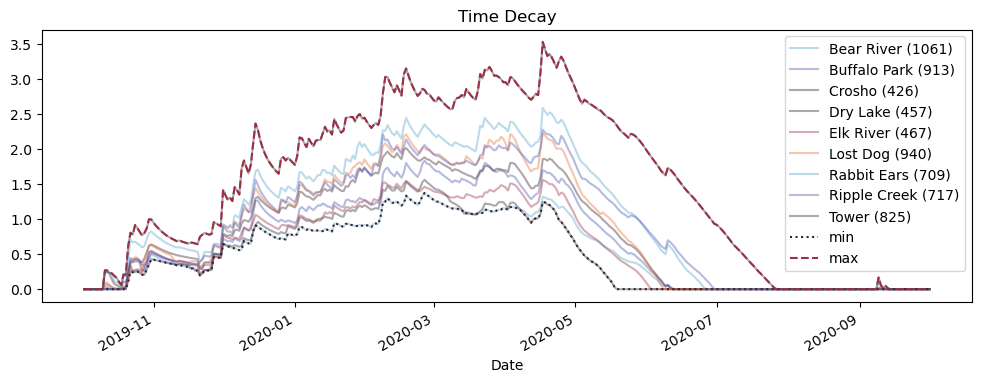

In [ ]:
# depth_megadf
fig, ax = plt.subplots(1, figsize=(12, 4))
for jdx, (sitenum, sitename, sdds) in enumerate(zip(sitenums, sitenames, sdd_list)):
    depth_megadf[sitenames.iloc[jdx]].plot(ax=ax, label=sitenames.iloc[jdx], alpha=0.4)
depth_megadf.min(axis=1).plot(ax=ax, label='min', linestyle=':')
depth_megadf.max(axis=1).plot(ax=ax, label='max', linestyle='--')
plt.legend()
plt.title('Time Decay');

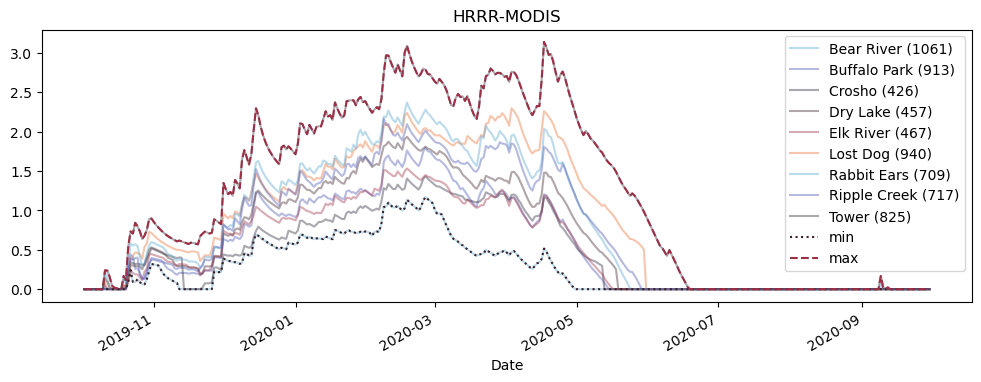

In [ ]:
# depth_sol_megadf
fig, ax = plt.subplots(1, figsize=(12, 4))
for jdx, (sitenum, sitename, sdds) in enumerate(zip(sitenums, sitenames, sdd_list)):
    depth_sol_megadf[sitenames.iloc[jdx]].plot(ax=ax, label=sitenames.iloc[jdx], alpha=0.4)
depth_sol_megadf.min(axis=1).plot(ax=ax, label='min', linestyle=':')
depth_sol_megadf.max(axis=1).plot(ax=ax, label='max', linestyle='--')
plt.legend()
plt.title('HRRR-MODIS');

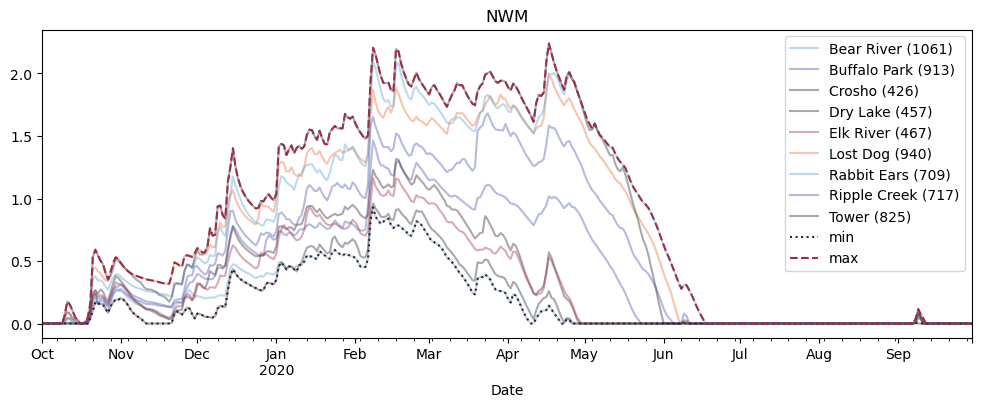

In [ ]:
# nwm_megadf
fig, ax = plt.subplots(1, figsize=(12, 4))
for jdx, (sitenum, sitename, sdds) in enumerate(zip(sitenums, sitenames, sdd_list)):
    nwm_megadf[sitenames.iloc[jdx]].plot(ax=ax, label=sitenames.iloc[jdx], alpha=0.4)
nwm_megadf.min(axis=1).plot(ax=ax, label='min', linestyle=':')
nwm_megadf.max(axis=1).plot(ax=ax, label='max', linestyle='--')
plt.legend()
plt.title('NWM');

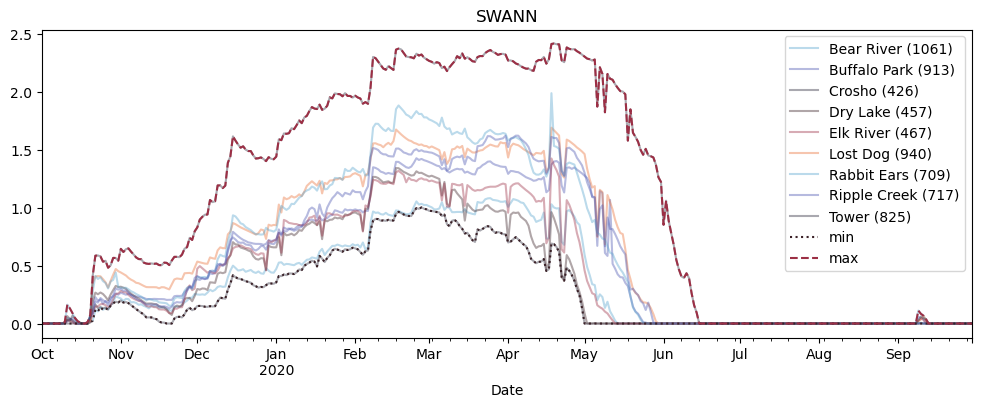

In [ ]:
# swann_megadf
fig, ax = plt.subplots(1, figsize=(12, 4))
for jdx, (sitenum, sitename, sdds) in enumerate(zip(sitenums, sitenames, sdd_list)):
    swann_megadf[sitenames.iloc[jdx]].plot(ax=ax, label=sitenames.iloc[jdx], alpha=0.4)
swann_megadf.min(axis=1).plot(ax=ax, label='min', linestyle=':')
swann_megadf.max(axis=1).plot(ax=ax, label='max', linestyle='--')
plt.legend()
plt.title('SWANN');

# Plot the compressed fig

# Archived

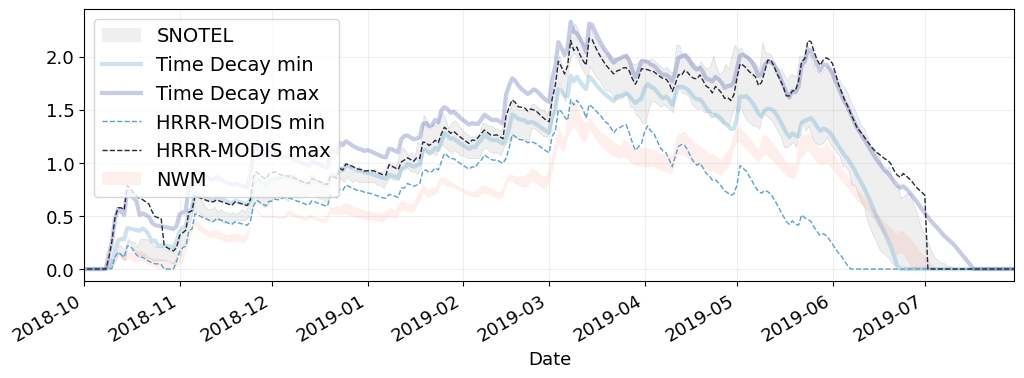

In [ ]:
alpha = 0.1
fig, ax = plt.subplots(1, figsize=figsize)


# # Plot WY time series of snow depth
# snotel_megadf.plot(ax=ax, legend=False,
#                    linewidth=linewidth/3,
#                    color=snotelcolor, marker='.', markersize=3,
#                    alpha=alpha*2
#                   )

snotel_megadf.min(axis=1).plot(ax=ax, legend=False,
                   # linewidth=0,
                   linewidth=linewidth/3,
                   color=snotelcolor, marker='.', markersize=0, #markersize=3,
                   alpha=alpha*2
                  )

snotel_megadf.max(axis=1).plot(ax=ax, legend=False,
                   # linewidth=0,
                   linewidth=linewidth/3,
                   color=snotelcolor, marker='.', markersize=0, #markersize=3,
                   alpha=alpha*2
                  )

ax.fill_between(snotel_megadf.index, 
                snotel_megadf.min(axis=1), 
                snotel_megadf.max(axis=1), facecolor=snotelcolor, label='SNOTEL', 
                alpha=alpha)

# iSnobal-HRRR
# ax.fill_between(depth_megadf.index, depth_megadf.min(axis=1), depth_megadf.max(axis=1), facecolor=isnobalcolors[0], label='iSnobal-HRRR', alpha=isnobal_alpha/4)
# depth_megadf.plot(ax=ax, label='iSnobal-HRRR', linewidth=linewidth*2, linestyle='-', 
#                     alpha=isnobal_alpha/2
#                  )
depth_megadf.min(axis=1).plot(ax=ax, label='Time Decay min', linewidth=linewidth*2, linestyle='-', 
                    alpha=isnobal_alpha/2
                 )
depth_megadf.max(axis=1).plot(ax=ax, label='Time Decay max', linewidth=linewidth*2, linestyle='-', 
                    alpha=isnobal_alpha/2
                 )

# HRRR-MODIS
# ax.fill_between(depth_sol_megadf.index, depth_sol_megadf.min(axis=1),depth_sol_megadf.max(axis=1), facecolor=isnobalcolors[1], label='HRRR-MODIS', alpha=isnobal_alpha/3)
# depth_sol_megadf.plot(ax=ax, label='HRRR-MODIS', linewidth=linewidth/3*2, linestyle='--', 
#                       color=sns.color_palette('icefire'),
#                      )
depth_sol_megadf.min(axis=1).plot(ax=ax, label='HRRR-MODIS min', linewidth=linewidth/3*2, linestyle='--', 
                                  color=sns.color_palette('icefire'),
                                 )
depth_sol_megadf.max(axis=1).plot(ax=ax, label='HRRR-MODIS max', linewidth=linewidth/3*2, linestyle='--',
                                 )


# NWM
ax.fill_between(nwm_megadf.index, nwm_megadf.min(axis=1), nwm_megadf.max(axis=1), facecolor=nwm_color, label='NWM', alpha=alpha)

# Center the plot on the data
ax.set_xlim(pd.Timestamp(f'{WY-1}-10-01'), pd.Timestamp(f'{WY}-07-30'));
if gridon:
    ax.grid(alpha=0.2)
plt.legend()
# plt.legend(bbox_to_anchor=(0.205,1))
# plt.legend(bbox_to_anchor=(0.195,1))

In [ ]:
depth_sol_megadf['Grizzly Peak (505)'].iloc[272:275].plot()

KeyError: 'Grizzly Peak (505)'

In [ ]:
%%time
# Plot that last day
blue_ds = xr.open_mfdataset(h.fn_list(basindirs[1], '*/snow.nc'), parallel=True)

CPU times: user 22.8 s, sys: 10.5 s, total: 33.3 s
Wall time: 23.7 s


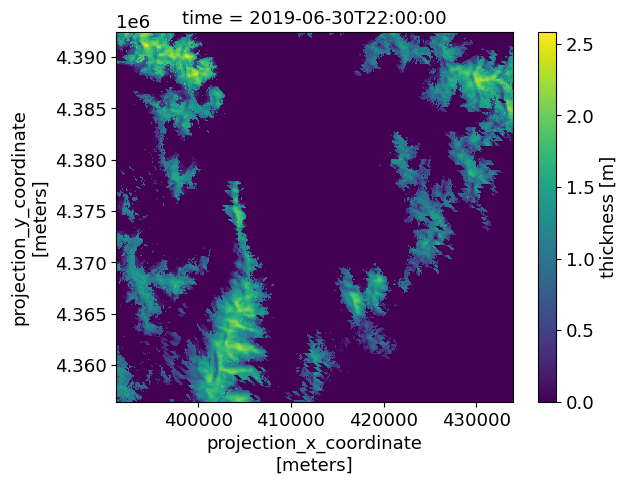

In [ ]:
blue_ds['thickness'].isel(time=272).plot.imshow()


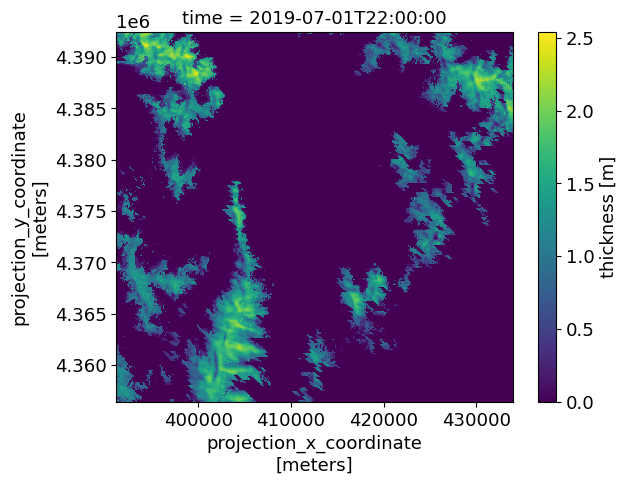

In [ ]:
blue_ds['thickness'].isel(time=273).plot.imshow()

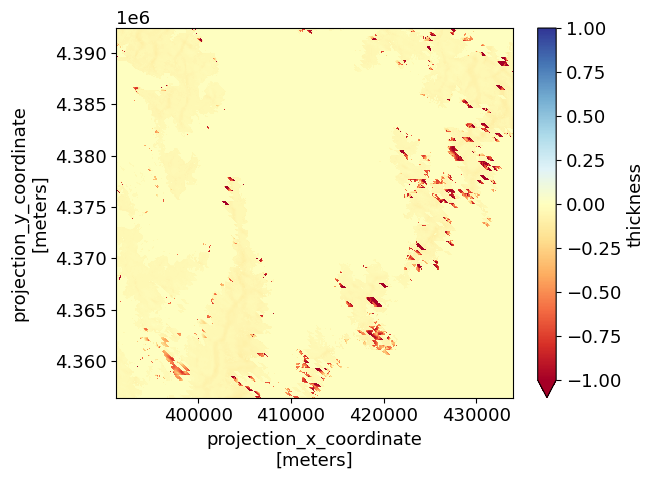

In [ ]:
(blue_ds['thickness'].isel(time=273) - blue_ds['thickness'].isel(time=272)).plot.imshow(cmap='RdYlBu', vmin=-1, vmax=1)

## Steep drop-off is probably due to SNOTEL sampling - nearest neighbor, should take average of 2x2 grid like Joe did in 2023 paper, need to tweak code for that (extract_isnobal_timeseries.py)